In [180]:
 #Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-03-22 12:53:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.6’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2024-03-22 12:53:22 (17.5 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.6’ saved [178509/178509]



In [181]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [182]:
# Load dataset
prices_raw_df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv')
prices_raw_df.head()

Currency        Date  Closing Price (USD)  24h Open (USD)  24h High (USD)  \
0      BTC  2013-10-01            123.65499       124.30466       124.75166   
1      BTC  2013-10-02            125.45500       123.65499       125.75850   
2      BTC  2013-10-03            108.58483       125.45500       125.66566   
3      BTC  2013-10-04            118.67466       108.58483       118.67500   
4      BTC  2013-10-05            121.33866       118.67466       121.93633   

   24h Low (USD)  
0      122.56349  
1      123.63383  
2       83.32833  
3      107.05816  
4      118.00566

In [183]:
prices = pd.DataFrame({"date":prices_raw_df['Date'],
                       "price":prices_raw_df['Closing Price (USD)']})
prices.head()

date      price
0  2013-10-01  123.65499
1  2013-10-02  125.45500
2  2013-10-03  108.58483
3  2013-10-04  118.67466
4  2013-10-05  121.33866

<Axes: >

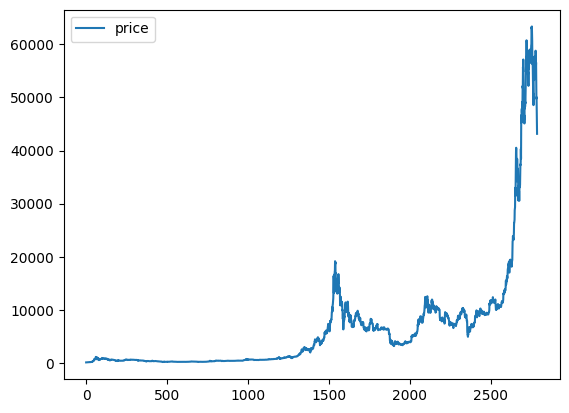

In [184]:
prices.plot()

### Adding reward price to dataset

In [185]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

Add Block reward value to dataframe

In [187]:
prices_reward = prices.copy()
prices_reward = prices_reward.astype({'date':np.datetime64})

In [188]:
prices_reward['block_reward'] = block_reward_1
prices_reward.loc[prices_reward['date'] >  block_reward_2_datetime, ['block_reward']] = block_reward_2
prices_reward.loc[prices_reward['date'] >  block_reward_3_datetime, ['block_reward']] = block_reward_3
prices_reward.loc[prices_reward['date'] >  block_reward_4_datetime, ['block_reward']] = block_reward_4

Since `block_reward` and `price` have different scales, we multiply `block_reward` by the price to the similar scale between variables.

In [190]:
prices_reward = prices_reward.set_index('date')
prices_reward['block_reward'] = prices_reward['block_reward']*prices_reward['price']
prices_reward.head(10)

price  block_reward
date                               
2013-10-01  123.65499    3091.37475
2013-10-02  125.45500    3136.37500
2013-10-03  108.58483    2714.62075
2013-10-04  118.67466    2966.86650
2013-10-05  121.33866    3033.46650
2013-10-06  120.65533    3016.38325
2013-10-07  121.79500    3044.87500
2013-10-08  123.03300    3075.82500
2013-10-09  124.04900    3101.22500
2013-10-10  125.96116    3149.02900

In [191]:
prices_reward.head()

price  block_reward
date                               
2013-10-01  123.65499    3091.37475
2013-10-02  125.45500    3136.37500
2013-10-03  108.58483    2714.62075
2013-10-04  118.67466    2966.86650
2013-10-05  121.33866    3033.46650

Scale indices to plot multivariate time serie on same plot

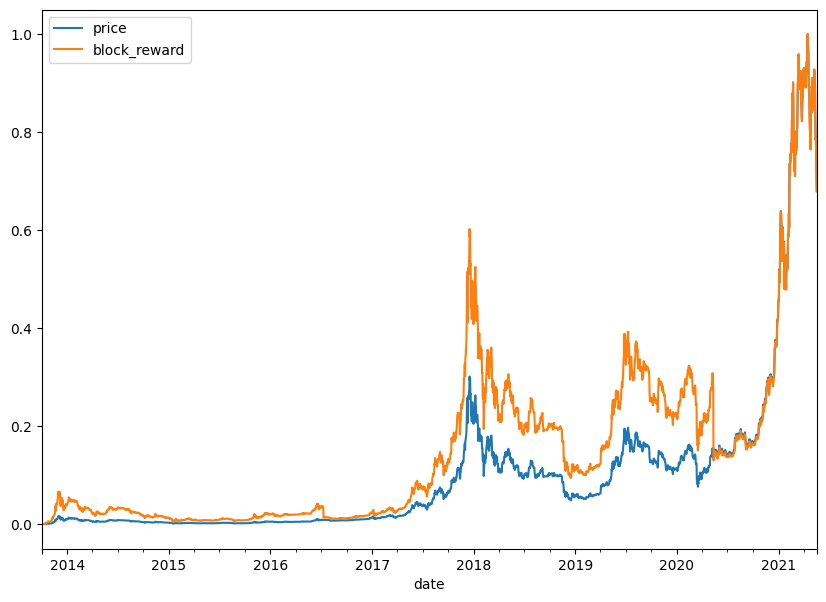

In [192]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(prices_reward[["price", "block_reward"]]), # we need to scale the data first
                                     columns=prices_reward.columns,
                                     index=prices_reward.index)
scaled_price_block_df.plot(figsize=(10, 7));

Making a windowed dataset

In [193]:
window = 7
prices_reward_windowed = prices_reward.copy()
for i in range(window):
  prices_reward_windowed[f'price+{i+1}']  =prices_reward_windowed['price'].shift(i+1)
prices_reward_windowed.head(10)

price  block_reward    price+1    price+2    price+3  \
date                                                                   
2013-10-01  123.65499    3091.37475        NaN        NaN        NaN   
2013-10-02  125.45500    3136.37500  123.65499        NaN        NaN   
2013-10-03  108.58483    2714.62075  125.45500  123.65499        NaN   
2013-10-04  118.67466    2966.86650  108.58483  125.45500  123.65499   
2013-10-05  121.33866    3033.46650  118.67466  108.58483  125.45500   
2013-10-06  120.65533    3016.38325  121.33866  118.67466  108.58483   
2013-10-07  121.79500    3044.87500  120.65533  121.33866  118.67466   
2013-10-08  123.03300    3075.82500  121.79500  120.65533  121.33866   
2013-10-09  124.04900    3101.22500  123.03300  121.79500  120.65533   
2013-10-10  125.96116    3149.02900  124.04900  123.03300  121.79500   

              price+4    price+5    price+6    price+7  
date                                                    
2013-10-01        NaN        NaN        NaN        NaN  
2013-10-02        NaN        NaN        NaN        NaN  
2013-10-03        NaN        NaN        NaN        NaN  
2013-10-04        NaN        NaN        NaN        NaN  
2013-10-05  123.65499        NaN        NaN        NaN  
2013-10-06  125.45500  123.65499        NaN        NaN  
2013-10-07  108.58483  125.45500  123.65499        NaN  
2013-10-08  118.67466  108.58483  125.45500  123.65499  
2013-10-09  121.33866  118.67466  108.58483  125.45500  
2013-10-10  120.65533  121.33866  118.67466  108.58483

#### Make train-test datasets

In [194]:
prices_reward_windowed

price   block_reward       price+1       price+2  \
date                                                                  
2013-10-01    123.654990    3091.374750           NaN           NaN   
2013-10-02    125.455000    3136.375000    123.654990           NaN   
2013-10-03    108.584830    2714.620750    125.455000    123.654990   
2013-10-04    118.674660    2966.866500    108.584830    125.455000   
2013-10-05    121.338660    3033.466500    118.674660    108.584830   
...                  ...            ...           ...           ...   
2021-05-14  49764.132082  311025.825510  52147.821187  56573.555472   
2021-05-15  50032.693137  312704.332105  49764.132082  52147.821187   
2021-05-16  47885.625255  299285.157842  50032.693137  49764.132082   
2021-05-17  45604.615754  285028.848460  47885.625255  50032.693137   
2021-05-18  43144.471291  269652.945568  45604.615754  47885.625255   

                 price+3       price+4       price+5       price+6  \
date                                                                 
2013-10-01           NaN           NaN           NaN           NaN   
2013-10-02           NaN           NaN           NaN           NaN   
2013-10-03           NaN           NaN           NaN           NaN   
2013-10-04    123.654990           NaN           NaN           NaN   
2013-10-05    125.455000    123.654990           NaN           NaN   
...                  ...           ...           ...           ...   
2021-05-14  55715.546651  58102.191426  58788.209679  57107.120672   
2021-05-15  56573.555472  55715.546651  58102.191426  58788.209679   
2021-05-16  52147.821187  56573.555472  55715.546651  58102.191426   
2021-05-17  49764.132082  52147.821187  56573.555472  55715.546651   
2021-05-18  50032.693137  49764.132082  52147.821187  56573.555472   

                 price+7  
date                      
2013-10-01           NaN  
2013-10-02           NaN  
2013-10-03           NaN  
2013-10-04           NaN  
2013-10-05           NaN  
...                  ...  
2021-05-14  56583.849879  
2021-05-15  57107.120672  
2021-05-16  58788.209679  
2021-05-17  58102.191426  
2021-05-18  55715.546651  

[2787 rows x 9 columns]

The BTC price distribution shows that BTC price is much higher in 2021 than it was before. We shuffle the dataframe to take into account the different scales during training/validation steps

In [195]:
from sklearn.utils import shuffle
prices_reward_windowed = shuffle(prices_reward_windowed)

In [196]:
X = prices_reward_windowed.dropna().drop(['price'], axis=1).astype(np.float32)
X.head()


block_reward       price+1       price+2       price+3  \
date                                                                  
2019-06-11   99425.078125   7600.922363   7949.425781   8030.255859   
2021-05-03  352669.031250  57677.976562  57302.644531  53260.296875   
2017-10-05   52334.796875   4307.555176   4424.472656   4414.177734   
2019-06-22  123830.101562   9559.900391   9259.124023   9012.488281   
2019-07-21  137290.203125  10466.260742  10603.348633   9733.131836   

                 price+4       price+5       price+6       price+7  
date                                                                
2019-06-11   7730.881836   7790.321289   7645.572754   8474.047852  
2021-05-03  54591.515625  55123.863281  53558.707031  48542.953125  
2017-10-05   4300.551270   4207.825195   4062.203857   4220.279785  
2019-06-22   9346.974609   9061.540039   8836.167969   8667.788086  
2019-07-21   9490.410156  10934.482422  10506.395508  11279.602539

In [197]:
y = prices_reward_windowed.dropna()['price'].astype(np.float32)
y.head()

date
2019-06-11     7954.006348
2021-05-03    56427.042969
2017-10-05     4186.783691
2019-06-22     9906.408203
2019-07-21    10983.215820
Name: price, dtype: float32

Split datasets into train/validation samples

In [198]:
split_size = int(len(X)*0.8)
X_train = X[:split_size]
y_train = y[:split_size]
X_test = X[split_size:]
y_test = y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [199]:
X_train.head()

block_reward       price+1       price+2       price+3  \
date                                                                  
2019-06-11   99425.078125   7600.922363   7949.425781   8030.255859   
2021-05-03  352669.031250  57677.976562  57302.644531  53260.296875   
2017-10-05   52334.796875   4307.555176   4424.472656   4414.177734   
2019-06-22  123830.101562   9559.900391   9259.124023   9012.488281   
2019-07-21  137290.203125  10466.260742  10603.348633   9733.131836   

                 price+4       price+5       price+6       price+7  
date                                                                
2019-06-11   7730.881836   7790.321289   7645.572754   8474.047852  
2021-05-03  54591.515625  55123.863281  53558.707031  48542.953125  
2017-10-05   4300.551270   4207.825195   4062.203857   4220.279785  
2019-06-22   9346.974609   9061.540039   8836.167969   8667.788086  
2019-07-21   9490.410156  10934.482422  10506.395508  11279.602539

### Preparing model

Computing best learning rate

In [200]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(100, activation="relu", input_shape=(None,1)),
 tf.keras.layers.Dense(1),
 ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mae',
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(X_train, y_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
70/70 [==============================] - 2s 8ms/step - loss: 6121.4219 - mae: 6121.4219 - lr: 1.0000e-04
Epoch 2/100
70/70 [==============================] - 1s 8ms/step - loss: 5060.7983 - mae: 5060.7983 - lr: 1.0798e-04
Epoch 3/100
70/70 [==============================] - 1s 8ms/step - loss: 3040.0640 - mae: 3040.0640 - lr: 1.1659e-04
Epoch 4/100
70/70 [==============================] - 1s 8ms/step - loss: 1177.8979 - mae: 1177.8979 - lr: 1.2589e-04
Epoch 5/100
70/70 [==============================] - 1s 8ms/step - loss: 615.7057 - mae: 615.7057 - lr: 1.3594e-04
Epoch 6/100
70/70 [==============================] - 1s 8ms/step - loss: 282.4577 - mae: 282.4577 - lr: 1.4678e-04
Epoch 7/100
70/70 [==============================] - 1s 7ms/step - loss: 268.7536 - mae: 268.7536 - lr: 1.5849e-04
Epoch 8/100
70/70 [==============================] - 1s 8ms/step - loss: 220.2505 - mae: 220.2505 - lr: 1.7113e-04
Epoch 9/100
70/70 [==============================] - 1s 7ms/step - loss:

(0.0001, 0.01, 0.0, 1500.0)

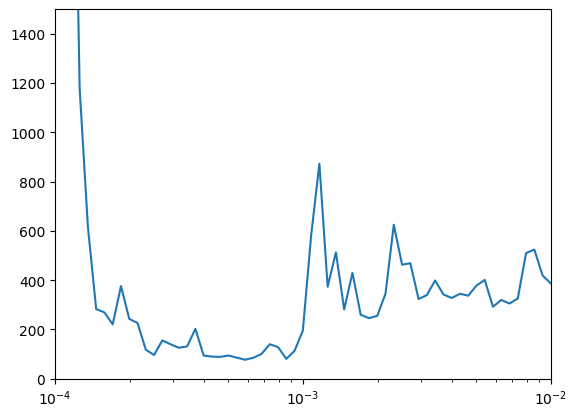

In [201]:
plt.semilogx(history.history["lr"], history.history["loss"], label="lr vs epoch")
plt.axis([1e-4, 1e-2, 00, 1500])

Training model with best learning rate estimation

In [202]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)





model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(100, activation="relu", input_shape=(None,1)),
 tf.keras.layers.Dense(1),
 ])

optimizer = tf.keras.optimizers.Adam(lr=3e-4)
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=["mae", 'mse'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
history = model.fit(X_train, y_train, epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
70/70 [==============================] - 4s 14ms/step - loss: 19172248.0000 - mae: 1645.4862 - mse: 19172248.0000 - val_loss: 22529856.0000 - val_mae: 1439.2024 - val_mse: 22529856.0000
Epoch 2/500
15/70 [=====>........................] - ETA: 0s - loss: 19632006.0000 - mae: 1427.8275 - mse: 19632006.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 1s 11ms/step - loss: 13622100.0000 - mae: 1489.3229 - mse: 13622100.0000 - val_loss: 3301341.7500 - val_mae: 1206.8174 - val_mse: 3301341.7500
Epoch 3/500
70/70 [==============================] - 1s 9ms/step - loss: 1663910.0000 - mae: 618.2516 - mse: 1663910.0000 - val_loss: 437992.5000 - val_mae: 286.3452 - val_mse: 437992.5000
Epoch 4/500
70/70 [==============================] - 1s 9ms/step - loss: 421492.3750 - mae: 388.6035 - mse: 421492.3750 - val_loss: 317022.0000 - val_mae: 313.4571 - val_mse: 317022.0000
Epoch 5/500
70/70 [==============================] - 1s 10ms/step - loss: 698633.0000 - mae: 329.7279 - mse: 698633.0000 - val_loss: 2900167.2500 - val_mae: 851.1951 - val_mse: 2900167.2500
Epoch 6/500
70/70 [==============================] - 1s 11ms/step - loss: 1684481.6250 - mae: 654.9385 - mse: 1684481.6250 - val_loss: 1604131.8750 - val_mae: 562.9634 - val_mse: 1604131.8750
Epoch 7/500
70/70 [==============================] - 1s 9m

In [209]:
model = tf.keras.models.load_model('my_checkpoint.h5')

In [210]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 24811.3730 - mae: 90.9224 - mse: 24811.3730


[24811.373046875, 90.92243194580078, 24811.373046875]

In [211]:
forecast = model.predict(X_test)

18/18 [==============================] - 0s 5ms/step


In [212]:
forecast.shape, X_test.shape

((556, 1), (556, 8))

In [213]:
tf.keras.metrics.mean_absolute_error(y_test, forecast[:,0])

<tf.Tensor: shape=(), dtype=float32, numpy=90.92245>

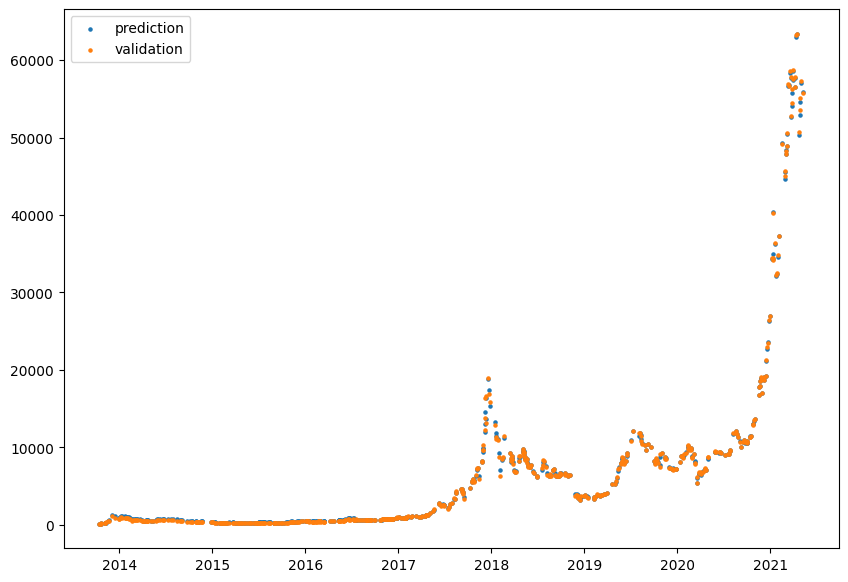

In [214]:
plt.figure(figsize=(10,7))
plt.scatter(X_test.index, forecast[:,0], s=5, label='prediction')
plt.scatter(X_test.index, y_test, s=5, label='validation')
plt.legend()